In [1]:
import os
import pandas as pd
from util import set_seed

RANDOM_STATE = 42
set_seed(RANDOM_STATE)
current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')

final_df = pd.read_csv(final_path)
selected_df = pd.read_csv(selected_path).drop(columns=['user_id']).values

### Przygotowanie danych

In [2]:
from util import prepare_final

final_df = prepare_final(final_df)

final_df.head()

,premium_user,popularity_mean,popularity_std,popularity_mode,popularity_median,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_mode,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.059379,-0.409611,-0.825471,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,1.503039,1.097880,2.270742,0.713372,0.661699,-0.043242,1.674050,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.429353,-0.963033,-0.008440,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.192440,-0.607767,-0.537427,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,1.382240,1.041270,0.544205,0.968310,0.678373,-0.770022,0.873527,...,0,1,1,1,1,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1).values
y = final_df['premium_user'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train_selected, X_test_selected, _, _ = train_test_split(selected_df, y, test_size=0.2, random_state=RANDOM_STATE)

### Klasyfikator XGboost

Szukanie parametrów

In [4]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch1.best_params_)
print("Best score: ", gsearch1.best_score_)

Best parameters found:  {'max_depth': 5, 'min_child_weight': 5}
Best score:  0.8830835958572416


In [6]:
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch2.best_params_)
print("Best score: ", gsearch2.best_score_)

Best parameters found:  {'max_depth': 4, 'min_child_weight': 5}
Best score:  0.8835314795267062


In [8]:
param_test2b = {
    'min_child_weight':[1,2,3,5,7,9,11]
}

gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2b.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch2b.best_params_)
print("Best score: ", gsearch2b.best_score_)

Best parameters found:  {'min_child_weight': 3}
Best score:  0.8835366496097933


In [9]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
    min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)

gsearch3.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch3.best_params_)
print("Best score: ", gsearch3.best_score_)

Best parameters found:  {'gamma': 0.3}
Best score:  0.8835866067436855


In [13]:
param_test3b = {
    'gamma':[i/100.0 for i in range(0,40)]
}

gsearch3b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test3b, scoring='roc_auc',n_jobs=4, cv=5)

gsearch3b.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch3b.best_params_)
print("Best score: ", gsearch3b.best_score_)

Best parameters found:  {'gamma': 0.28}
Best score:  0.8836844952680136


In [14]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(3,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=4,
    min_child_weight=3, gamma=0.28, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, cv=5)

gsearch4.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch4.best_params_)
print("Best score: ", gsearch4.best_score_)

Best parameters found:  {'colsample_bytree': 0.3, 'subsample': 0.8}
Best score:  0.8836157211127638


In [16]:
param_test4b = {
    'subsample':[i/100.0 for i in range(70,90,2)],
    'colsample_bytree':[i/100.0 for i in range(20,40,2)]
}

gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=4,
    min_child_weight=3, gamma=0.28, subsample=0.8, colsample_bytree=0.3,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test4b, scoring='roc_auc',n_jobs=4, cv=5)

gsearch4b.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch4b.best_params_)
print("Best score: ", gsearch4b.best_score_)

Best parameters found:  {'colsample_bytree': 0.3, 'subsample': 0.72}
Best score:  0.8838839990444566


In [17]:
param_test5 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=4,
    min_child_weight=3, gamma=0.28, subsample=0.72, colsample_bytree=0.3,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)

gsearch5.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch5.best_params_)
print("Best score: ", gsearch5.best_score_)

Best parameters found:  {'reg_alpha': 1e-05}
Best score:  0.8838840168352938


In [11]:
param_test5 = {
    'reg_alpha':[i/100000.0 for i in range(0,100,10)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=4,
    min_child_weight=3, gamma=0.28, subsample=0.72, colsample_bytree=0.3,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=RANDOM_STATE), 
    param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)

gsearch5.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch5.best_params_)
print("Best score: ", gsearch5.best_score_)

Best parameters found:  {'reg_alpha': 0.0004}
Best score:  0.8838841236086921


Uczenie

In [9]:
clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=3,
    gamma=0.28,
    subsample=0.72,
    colsample_bytree=0.3,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha=0.0004,
    eval_metric='auc',
    random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.8110
ROC AUC: 0.8741
Precision: 0.8153
Recall: 0.7072
F1 Score: 0.7574


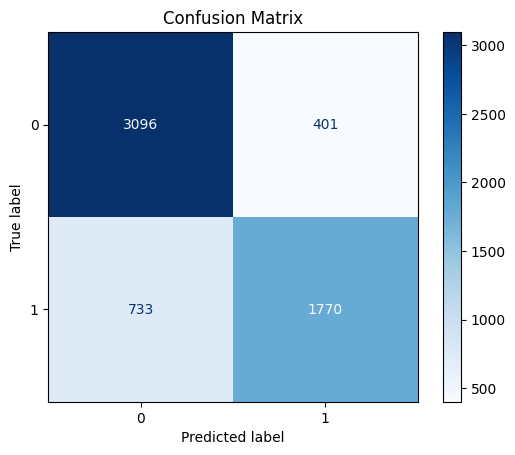

In [10]:
from util import show_metrics

show_metrics(y_test, y_pred, y_pred_proba)

Po selekcji atrybutów

In [18]:
clf_selected = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=3,
    gamma=0.28,
    subsample=0.72,
    colsample_bytree=0.3,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha=0.0004,
    eval_metric='auc',
    random_state=RANDOM_STATE)
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict(X_test_selected)
y_pred_proba_selected = clf_selected.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.8105
ROC AUC: 0.8752
Precision: 0.8153
Recall: 0.7056
F1 Score: 0.7565


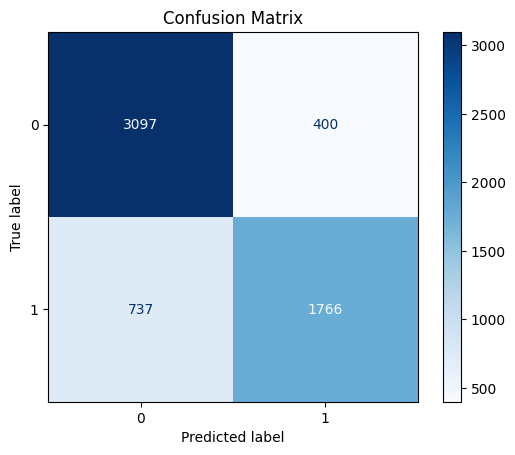

In [19]:
show_metrics(y_test, y_pred_selected, y_pred_proba_selected)

Save models

In [20]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'xgb_model.joblib')
model_selected_path = os.path.join(current_dir, 'trained', 'xgb_selected_model.joblib')

joblib.dump(clf, model_path)
joblib.dump(clf_selected, model_selected_path)

['d:\\_prog\\Projekty\\Account-Classifier\\models\\trained\\xgb_selected_model.joblib']